# Assignment 5

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [1]:
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import urllib
import string
import requests
import requests_cache
import pandas as pd
import numpy as np
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def page_scrapy (para, npg):
    """
    This function is to extract all of the links on a given url and given number of pages
    
    Input: string @para: this is the topics you want to scrapy from theaggie.org/
           npg @int: the number of pages you want to scarpy
    Output: list of urls
    
    """
    urls = [] # this is where we save a list of urls 
    
    for i in range(1, npg+1):
        url = 'https://theaggie.org/' + para + '/page/' + str(i) 
        try: 
            requests_cache.install_cache("cache") 
            url_link = requests.get(url) 
            url_link.raise_for_status()
            soup = BeautifulSoup(url_link.text)
            letters = soup.find_all("h2", class_="entry-title") #urls is under h2 "entry-title"
            for j in range(15): # every page we have 15 articles
                urls.append(letters[j].a['href']) 
        except Exception, e: # that means we reach the end of the categories before the page requested
                             # for example, we only have 2 pages, but we request 20 pages. It will end at 2
            return urls 
        
    return urls


In [3]:
page_scrapy('opinion',2) # this is a test

//anaconda/envs/141b/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file //anaconda/envs/141b/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


['https://theaggie.org/2017/02/20/reverse-trend-of-low-voter-turnout/',
 'https://theaggie.org/2017/02/20/humorpanicking-students-just-throws-one-thing-into-each-type-of-trash-can/',
 'https://theaggie.org/2017/02/20/question-the-value-of-private-and-charter-schools/',
 'https://theaggie.org/2017/02/19/humor-school-to-install-stop-sign-near-death-star-to-distract-from-tuition-hikes/',
 'https://theaggie.org/2017/02/19/the-resurgence-of-orwells-1984/',
 'https://theaggie.org/2017/02/19/senate-endorsements-consider-the-following-5/',
 'https://theaggie.org/2017/02/17/dont-make-tuition-increases-inevitable/',
 'https://theaggie.org/2017/02/17/humor-if-einstein-is-so-smart-why-is-he-dead/',
 'https://theaggie.org/2017/02/17/humor-i-am-a-trash-person-and-i-am-proud/',
 'https://theaggie.org/2017/02/16/rekindle-the-affirmative-action-conversation/',
 'https://theaggie.org/2017/02/15/cartoon-michael-flynn-gets-a-valentine/',
 'https://theaggie.org/2017/02/14/humor-hero-student-reminds-us-all-

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

*   Python 2 displays some Unicode characters as `\uXXXX`. For instance, `\u201c` is a left-facing quotation mark.
    You can convert most of these to ASCII characters with the method call (on a string)
    ```
    .translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    ```
    If you're curious about these characters, you can look them up on [this page](http://unicode.org/cldr/utility/character.jsp), or read 
    more about [what Unicode is](http://unicode.org/standard/WhatIsUnicode.html).

In [4]:
def url_scrapy(url):
    """
    This function is to extract the author, text title and url from a given url
    
    Input: string @url: the url you want to know everything about
    Output: a dictionary of information we need
    
    """
    requests_cache.install_cache("cache")
    url_link = requests.get(url)
    url_link.raise_for_status()
    soup = BeautifulSoup(url_link.text)
    article = {} # this is the dictionary store all the information
    
    author = ''
    aut = soup.find("div",itemprop = "articleBody")
    if aut.find_all("p")[-1].find_all(['strong']) != []:
        author = aut.find_all("p")[-1].find_all(['b', 'strong'])[0].get_text()
    else:
        for i in aut.find_all("p")[-1].find_all(['b', 'strong','a']):
            author = author + ' ' + i.get_text()
    article['author'] = author
    
    text = ''
    for p in soup.find(itemprop="articleBody").find_all("p")[:-1]:
        text = text + ' ' + p.get_text().translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    article['text'] = text
    article['title'] = soup.find("h1", class_="entry-title").text
    article['url'] = url
    return article

In [5]:
url_scrapy("https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/")

{'author': u' Written By: Bianca Antunez \xa0\u2014 city@theaggie.org',
 'text': u' Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design.  Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager.  "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [6]:
campus_n = page_scrapy('campus',4)
campus = pd.DataFrame()
for i in campus_n:
    items = url_scrapy(i)
    new_df = pd.DataFrame([items])
    campus = campus.append(new_df)
campus["category"] = 'campus'

In [7]:
campus.head()

,author,text,title,url,category
0,Written by: Jeanna Totah — campus@theaggie.org,Tighter policies require greater approval of ...,Katehi controversy prompts decline of UC admin...,https://theaggie.org/2017/02/20/katehi-controv...,campus
0,Written by: Ivan Valenzuela — campus@theaggie...,SR #7 asks university to increase capacity fo...,ASUCD Senate passes resolution submitting comm...,https://theaggie.org/2017/02/20/asucd-senate-p...,campus
0,Written by: Yvonne Leong — campus@theaggie.org,UC Davis leads in sustainability with largest...,UC releases 2016 Annual Report on Sustainable ...,https://theaggie.org/2017/02/20/uc-releases-20...,campus
0,Written by: Kenton Goldsby — campus@theaggie.org,"Speakers, including Interim Chancellor Ralph ...",UC Davis Global Affairs holds discussion on Pr...,https://theaggie.org/2017/02/19/uc-davis-globa...,campus
0,Written by: Kimia Akbari — campus@theaggie.org,Executive order has immediate consequences fo...,Trump’s immigration ban affects UC Davis commu...,https://theaggie.org/2017/02/19/trumps-immigra...,campus


In [8]:
city_n = page_scrapy('city',4)
city = pd.DataFrame()
for i in city_n:
    items = url_scrapy(i)
    new_df = pd.DataFrame([items])
    city = city.append(new_df)
city["category"] = 'city'

In [9]:
city.head()

,author,text,title,url,category
0,Written By: Anya Rehon — city@theaggie.org,"CalRecycle donates $197,851 The City of Davis...",City of Davis awarded funds for new recycling ...,https://theaggie.org/2017/02/20/city-of-davis-...,city
0,Written by: Sam Solomon city@theaggie.org,"The world is a weird place Feb. 6 ""Chronic ph...",Police Logs,https://theaggie.org/2017/02/19/police-logs-12/,city
0,Written by: Raul Castellanos Jr — city@theagg...,Mayor Robb Davis reaffirms that the City of D...,City of Davis to retain sanctuary city status,https://theaggie.org/2017/02/16/city-of-davis-...,city
0,Written by: Samantha Solomon — city@theaggie.org,Davis resident Lauren Kirk-Coehlo arrested in...,Suspect in Davis Islamic Center vandalism arre...,https://theaggie.org/2017/02/15/suspect-in-dav...,city
0,Written By: Bianca Antunez — city@theaggie.org,Davis residents create financial model to mak...,Project Toto aims to address questions regardi...,https://theaggie.org/2017/02/14/project-toto-a...,city


In [10]:
campus_city = pd.DataFrame()
campus_city = campus_city.append(campus)
campus_city = campus_city.append(city)
campus_city = campus_city.reset_index(drop=True)
campus_city

,author,text,title,url,category
0,Written by: Jeanna Totah — campus@theaggie.org,Tighter policies require greater approval of ...,Katehi controversy prompts decline of UC admin...,https://theaggie.org/2017/02/20/katehi-controv...,campus
1,Written by: Ivan Valenzuela — campus@theaggie...,SR #7 asks university to increase capacity fo...,ASUCD Senate passes resolution submitting comm...,https://theaggie.org/2017/02/20/asucd-senate-p...,campus
2,Written by: Yvonne Leong — campus@theaggie.org,UC Davis leads in sustainability with largest...,UC releases 2016 Annual Report on Sustainable ...,https://theaggie.org/2017/02/20/uc-releases-20...,campus
3,Written by: Kenton Goldsby — campus@theaggie.org,"Speakers, including Interim Chancellor Ralph ...",UC Davis Global Affairs holds discussion on Pr...,https://theaggie.org/2017/02/19/uc-davis-globa...,campus
4,Written by: Kimia Akbari — campus@theaggie.org,Executive order has immediate consequences fo...,Trump’s immigration ban affects UC Davis commu...,https://theaggie.org/2017/02/19/trumps-immigra...,campus
5,Written by: Kaitlyn Cheung — campus@theaggie.org,Student protesters march from MU flagpole to ...,UC Davis students participate in UC-wide #NoDA...,https://theaggie.org/2017/02/17/uc-davis-stude...,campus
6,Written by: Jayashri Padmanabhan — campus@thea...,"Conference entails full day of speakers, pane...",UC Davis holds first mental health conference,https://theaggie.org/2017/02/17/uc-davis-holds...,campus
7,Written by: Demi Caceres — campus@theaggie.org,Last week in Senate The ASUCD Senate meeting ...,Last week in Senate,https://theaggie.org/2017/02/16/last-week-in-s...,campus
8,Written by: Alyssa Vandenberg and Emilie DeFaz...,Executive: Josh Dalavai and Adilla Jamaludin ...,2017 ASUCD Winter Elections — Meet the Candidates,https://theaggie.org/2017/02/16/2017-asucd-win...,campus
9,Written by: Ivan Valenzuela — campus@theaggie.org,New showcase provides opportunity for student...,Shields Library hosts new exhibit for Davis ce...,https://theaggie.org/2017/02/14/shields-librar...,campus


__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

_1._ **What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?**

In [11]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize # do tokenization, remove white space, get a list of words 

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization, stemming and remove stopwords
    Input: string
    Output: list of strings (lemmata)
    """
    tokens = tokenize(text)
    tokens = [w for w in tokens if w.lower() not in stopwords] # remove the stopwords such as I, me, myself, we, our etc.
    return stem(tokens) # removing morphological affixes from words

In [12]:
def fid_tf(term, tokenized_document):
    """
    This function is to calculate the term frequency within the documents
    Input: string @term, the words you want to serach for frequency
                  @tokenized_document, tokenized document
    Output: float, the term freuncy in this document
    """
    return float(tokenized_document.count(term))/len(tokenized_document)

def fid_idf(files):
    """
    This function is to calculate the term frequency in all the documents
    Input: string @files, a list of all the files
    Output: dict, the term is key, the frequency is the value
    """
    docid = 0
    textd = {}
    for fid in files:
        s = set(lemmatize(fid))
        try:
            toks = toks | s
        except NameError:
            toks = s
        for tok in s:
            try:
                textd[tok].append(docid)
            except KeyError:
                textd[tok] = [docid]
        docid += 1
    numd = {key:len(set(val)) for key,val in textd.items()}
    logN = np.log(len(files))
    idf_smooth = {key:logN - np.log(1 + val) for key, val in numd.items() if val > 1}
    return idf_smooth

def tf_idf(files):
    """
    This function is to calculate the tf-idf
    Input: string @files, a list of all the files
    Output: dict, the term is key, the frequency is the tf-idf
    """
    idf = fid_idf(files)
    tfidf_topic = {}
    docid = 0
    for fid in files:
        tokenized_document = lemmatize(fid)
        term_tfidf = {}
        for term in idf.keys():
            tf = fid_tf(term, tokenized_document)
            term_tfidf[term] = (tf * idf[term])
        topic = sorted(term_tfidf, key=term_tfidf.get, reverse=True)[:1]
        tfidf_topic[docid] = topic
        docid += 1
    return tfidf_topic

In [13]:
fid_idf(campus_city["text"])

{u'1,800': 3.6888794541139358,
 u'hatr': 3.401197381662155,
 u'four': 2.3025850929940455,
 u'protest': 1.8971199848858813,
 u'sleep': 3.401197381662155,
 u'asian': 3.401197381662155,
 u'oldest': 3.6888794541139358,
 u'hate': 2.3025850929940455,
 u'whose': 3.1780538303479453,
 u'accus': 3.6888794541139358,
 u'accur': 3.6888794541139358,
 u'tweet': 3.6888794541139358,
 u'bike': 2.8415815937267324,
 u'@': 3.401197381662155,
 u'everi': 1.4201959127955717,
 u'risk': 2.3895964699836751,
 u'compassion': 3.6888794541139358,
 u'blanket': 3.6888794541139358,
 u'rise': 2.9957322735539909,
 u'voic': 2.2225423853205091,
 u'tenni': 3.6888794541139358,
 u'jack': 3.6888794541139358,
 u'unitran': 3.6888794541139358,
 u'govern': 2.0149030205422647,
 u'jacob': 3.6888794541139358,
 u'appar': 3.6888794541139358,
 u'month': 1.6519975268528961,
 u'vast': 3.6888794541139358,
 u'school': 1.3217558399823193,
 u'scholar': 3.401197381662155,
 u'\u2013\u2013': 3.1780538303479453,
 u'enjoy': 1.8430527636156055,
 u'

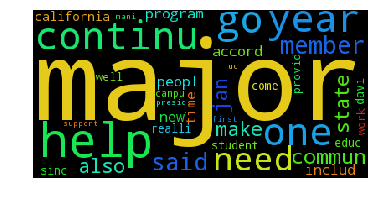

[u'said',
 u'davi',
 u'also',
 u'uc',
 u'commun',
 u'year',
 u'student',
 u'one',
 u'work',
 u'peopl']

In [14]:
aggie = fid_idf(campus_city["text"])
aggie_topic = sorted(aggie, key=aggie.get, reverse=False)[:50]
aggie_topics = [i for i in aggie_topic if i not in [u'.',u"''",u'``',u',',u"'s",u'[',u']',u'(',u')',u"'",u"n't",u'[',u']']]

wordcloud = WordCloud().generate(', '.join(aggie_topics))
# Open a plot of the generated image.
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
aggie_topics[:10]

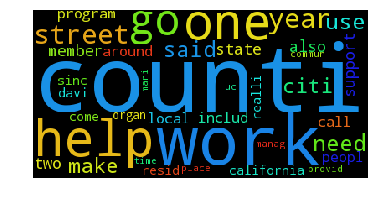

[u'said',
 u'davi',
 u'year',
 u'commun',
 u'one',
 u'peopl',
 u'mani',
 u'make',
 u'like',
 u'time']

In [15]:
city = fid_idf(campus_city[campus_city["category"] == "city"]["text"])
city_topic = sorted(city, key=city.get, reverse=False)[:50]
city_topics = [i for i in city_topic if i not in [u'.',u"''",u'``',u',',u"'s",u'[',u']',u'(',u')',u"'",u"n't",u'[',u']']]


wordcloud = WordCloud().generate(', '.join(city_topics))
# Open a plot of the generated image.
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

city_topics[:10]

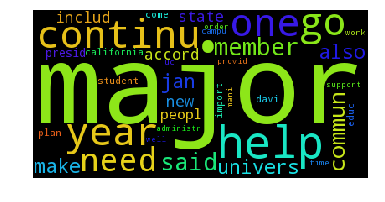

[u'uc',
 u'student',
 u'said',
 u'davi',
 u'also',
 u'campu',
 u'work',
 u'univers',
 u'major',
 u'one']

In [16]:
campus = fid_idf(campus_city[campus_city["category"] == "campus"]["text"])
campus_topic = sorted(campus, key=campus.get, reverse=False)[:50]
campus_topics = [i for i in campus_topic if i not in [u'.',u"''",u'``',u',',u"'s",u'[',u']',u'(',u')',u"'",u"n't",u'[',u']']]

wordcloud = WordCloud().generate(', '.join(campus_topics))
# Open a plot of the generated image.
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

campus_topics[:10]

**The topics Aggie and campus cover are almost the same. The topics city cover is a bit different**

In [17]:
d = {'Aggie topics': aggie_topics[:10], 'Campus topics':campus_topics[:10], 'City topics':city_topics[:10]}
pd.DataFrame(data=d)

,Aggie topics,Campus topics,City topics
0,said,uc,said
1,davi,student,davi
2,also,said,year
3,uc,davi,commun
4,commun,also,one
5,year,campu,peopl
6,student,work,mani
7,one,univers,make
8,work,major,like
9,peopl,one,time


**In a summary, the Aggie topics are about UC Davis students, work and people. The Campus topics are about UC Davis  studnets, campus, university and major. The City topics cover Davis, and people.**

_2._ **What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?**

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
vectorizer = TfidfVectorizer(max_df = 0.8, max_features = 200000, min_df = 0.2, stop_words = 'english',
                                 use_idf = True, tokenizer = lemmatize, smooth_idf = True)

tfidf_matrix = vectorizer.fit_transform(campus_city["text"]) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(120, 136)


In [19]:
sim = tfidf_matrix.dot(tfidf_matrix.T)

In [20]:
docids = {} #dictionary of the document id to an integer id for the document
N = len(campus_city["text"])
for i in xrange(N):
    docids[campus_city["text"][i]] = i
docids

{u'  GreenMetric names UC Davis the greenest university overall The University of Indonesia\'s seventh annual Greenmetric ranking has declared UC Davis the world\'s most sustainable university.  By using environmental conservation and carbon footprint reduction criteria, UC Davis achieved an aggregate score of 8,396 out of 10,000, while the two runner-ups scored 8,079 and 7,658. UC Davis was ranked highest out of the universities for transportation, including bus and bike usage as part of environmentally-friendly public transportation. \xa0 UC Davis also achieved a perfect score of 1,800 in the waste section, regarding waste treatment, recycling, paper and plastic policies and sewerage disposal.  The ranking, which was announced on Dec. 16, highlights universities that are combating global climate change as well as bolstering energy and water conservation, waste recycling and green transportation.  UC Davis scored far ahead of other University of California (UC) campuses, with UC Berke

In [21]:
simpairs = {}
for i in range(120):
    for j in range(120):
        simpairs[(i,j)] = sim[(i,j)]
simlarity_aggie = sorted(simpairs, key=simpairs.get, reverse=True)[:10]

In [22]:
import operator
sorted(simpairs.items(), key=operator.itemgetter(1),reverse=True)

[((21, 21), 1.0000000000000009),
 ((16, 16), 1.0000000000000007),
 ((117, 117), 1.0000000000000007),
 ((38, 38), 1.0000000000000007),
 ((105, 105), 1.0000000000000007),
 ((116, 116), 1.0000000000000007),
 ((42, 42), 1.0000000000000007),
 ((8, 8), 1.0000000000000007),
 ((85, 85), 1.0000000000000004),
 ((41, 41), 1.0000000000000004),
 ((69, 69), 1.0000000000000004),
 ((15, 15), 1.0000000000000004),
 ((17, 17), 1.0000000000000004),
 ((101, 101), 1.0000000000000004),
 ((48, 48), 1.0000000000000004),
 ((20, 20), 1.0000000000000004),
 ((115, 115), 1.0000000000000004),
 ((75, 75), 1.0000000000000004),
 ((47, 47), 1.0000000000000004),
 ((6, 6), 1.0000000000000004),
 ((87, 87), 1.0000000000000004),
 ((91, 91), 1.0000000000000004),
 ((25, 25), 1.0000000000000004),
 ((45, 45), 1.0000000000000002),
 ((35, 35), 1.0000000000000002),
 ((107, 107), 1.0000000000000002),
 ((111, 111), 1.0000000000000002),
 ((71, 71), 1.0000000000000002),
 ((14, 14), 1.0000000000000002),
 ((109, 109), 1.0000000000000002)

**Therefore, except themselves, the most similar pairs are 44 and 8, 8 and 47, 6 and 8.**

In [24]:
print("The most similar pair is %s AND %s"%(campus_city["title"][16],campus_city["title"][30]))
print("The second most similar pair is %s AND %s"%(campus_city["title"][47],campus_city["title"][57]))
print("The third similar pair is %s AND %s"%(campus_city["title"][16],campus_city["title"][54]))

The most similar pair is Student organizers host “Change/The Conversation” event AND 2017 ASUCD Winter Elections — Meet the Candidates
The second most similar pair is Student regent recruitment for the 2018-2019 school year begins AND 2017 ASUCD Winter Elections — Meet the Candidates
The third similar pair is UC Davis holds first mental health conference AND 2017 ASUCD Winter Elections — Meet the Candidates


**The most similar pair common words**

In [32]:
def common_words(file1, file2):
    """
    This function is to find out the common words between two files
    Input: int @file1, index of file 1
           int @file2, index of file 2
    Output: dict, a dictionary of common words in file 1 and 2
    """
    list1 = lemmatize(campus_city["text"][file1])
    list2 = lemmatize(campus_city["text"][file2])
    return set(list1)&set(list2)

In [33]:
print("These are the words %s and %s have in common"%(campus_city["title"][16],campus_city["title"][30]))
common_words(16,30)

These are the words University of California Regents meet, approve first tuition raise in six years and UC Regents vote to raise tuition for UC campuses have in common


{u'$',
 u"''",
 u"'s",
 u'(',
 u')',
 u',',
 u'.',
 u'26',
 u'282',
 u'336',
 u'54',
 u'[',
 u']',
 u'``',
 u'afford',
 u'alex',
 u'among',
 u'asucd',
 u'california',
 u'commit',
 u'cost',
 u'crisi',
 u'debat',
 u'direct',
 u'fee',
 u'first',
 u'gavin',
 u'higher',
 u'hook',
 u'increas',
 u'jan.',
 u'lee',
 u'let',
 u"n't",
 u'new',
 u'newsom',
 u'place',
 u'presid',
 u'public',
 u'rais',
 u'regent',
 u'said',
 u'servic',
 u'sinc',
 u'student',
 u'tuition',
 u'uc',
 u'vote',
 u'year',
 u'\u2014'}

**The second most similar pair common words**

In [30]:
print("These are the words %s and %s have in common"%(campus_city["title"][47],campus_city["title"][57]))
common_words(47,57)

These are the words Student regent recruitment for the 2018-2019 school year begins and Students walk out of classes to protest potential tuition hikes have in common


{u"''",
 u"'s",
 u',',
 u'.',
 u'1',
 u'``',
 u'administr',
 u'afford',
 u'barbara',
 u'board',
 u'california',
 u'campu',
 u'creat',
 u'davi',
 u'educ',
 u'ensur',
 u'everi',
 u'fee',
 u'five',
 u'fund',
 u'higher',
 u'hous',
 u'issu',
 u'manag',
 u'need',
 u'one',
 u'plan',
 u'priorit',
 u'regard',
 u'regent',
 u'said',
 u'santa',
 u'sinc',
 u'student',
 u'system',
 u'uc',
 u'undergradu',
 u'univers',
 u'voic',
 u'work',
 u'year'}

**The third most similiar pair common words**

In [31]:
print("These are the words %s and %s have in common"%(campus_city["title"][16],campus_city["title"][54]))
common_words(16,54)

These are the words University of California Regents meet, approve first tuition raise in six years and UC, CSU systems consider first tuition increases after five-year tuition freeze have in common


{u'$',
 u"''",
 u"'s",
 u"'ve",
 u'(',
 u')',
 u',',
 u'.',
 u'282',
 u'54',
 u'[',
 u']',
 u'``',
 u'afford',
 u'alreadi',
 u'also',
 u'although',
 u'approv',
 u'budget',
 u'california',
 u'class',
 u'continu',
 u'cost',
 u'could',
 u'despit',
 u'explain',
 u'fall',
 u'fee',
 u'find',
 u'first',
 u'fulli',
 u'fund',
 u'go',
 u'governor',
 u'higher',
 u'includ',
 u'increas',
 u'last',
 u'less',
 u'like',
 u'mani',
 u'may',
 u'million',
 u"n't",
 u'one',
 u'per',
 u'present',
 u'presid',
 u'provid',
 u'rais',
 u'recent',
 u'regent',
 u'resid',
 u'said',
 u'school',
 u'secur',
 u'servic',
 u'six',
 u'state',
 u'student',
 u'support',
 u'system',
 u'tuition',
 u'uc',
 u'univers',
 u'us',
 u'work',
 u'year',
 u'\u2014'}

__3. **Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.**

**I think it is a good representative of the Aggie. Because it captured the most important information on aggie.org which is news. We can inference that campus news is a good representative of the entire Aggie website. The common words in the campus news are the same as the combination of campus news and city news.** 